In [1]:
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.8/
!export CUDA_DIR="/usr/local/cuda-11.8/"
!export TF_GPU_ALLOCATOR=cuda_malloc_async

In [2]:
import tensorflow as tf
import tensorflow.keras as keras


gpus = tf.config.list_physical_devices("GPU")
print(f"gpus={gpus}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import tensorflow_addons as tfa
import datetime
import random
import time

2022-11-15 07:58:59.525440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 07:58:59.617563: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 07:59:00.011514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/home/pedro/miniconda3/envs/ml2/lib/:/usr/local/cuda-11.8/lib64/lib
2022-11-15 07:59:00.011555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

gpus=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
mnist = tf.keras.datasets.fashion_mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()

2022-11-15 07:59:01.231281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 07:59:01.331624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 07:59:01.331830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 07:59:01.332009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

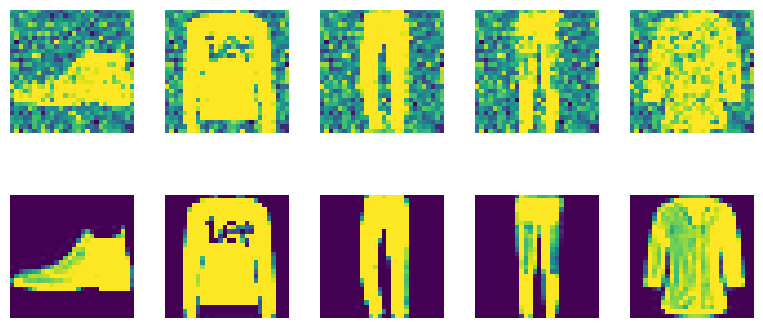

In [4]:
from utils import NoiseUtil, ImgUtils, DataLoader, DataManager
           
def train_get():
   for x, y in zip(x_train, y_train):
        x = tf.expand_dims(x, axis=2)
        yield x

def test_get():
   for x in x_test:
        x = tf.expand_dims(x, axis=2)
        yield x


def add_noise(x,y):
#     n = NoiseUtil.pixel_noise(x, 25, 5)

    n = x + 0.4 * tf.random.normal(
        x.shape[1:],
        mean=0.0,
        stddev=1.0,
        dtype=tf.dtypes.float32,
    )

    return n,y
dm = DataManager.create_label_with_input_transform(train_get, test_get, (28,28,1), add_noise)
dm.print_validation() 

In [5]:
# it = iter(dm.get_test_data(2))
# i,j = next(it)
# plt.imshow(ImgUtils.denormalize(j, cast=tf.uint8)[1])
# plt.figure()
# plt.imshow(ImgUtils.denormalize(NoiseUtil.pixel_noise(j, 10, 5), cast=tf.uint8)[1])

In [6]:
# im = tf.reshape(tf.constant(range(2*12*12*1)), (2,12,12,1))

# NoiseUtil.pixel_noise(im, 10, 2)[:,:,:,0]

In [7]:
print(x_test[0].shape)

(28, 28)


In [8]:
LATENT_SIZE = 32

In [9]:
def get_conv_t(filters, norm=False):
    conv = tf.keras.Sequential()
    if norm:
        conv.add(tfa.layers.SpectralNormalization(
            layers.Conv2DTranspose(filters, 2, 2, padding="same")
        ))
    else:
        conv.add(layers.Conv2DTranspose(filters, 2, 2, padding="same"))
    conv.add(layers.LeakyReLU())
    return conv

class InceptionBlock(layers.Layer):

    def __init__(self, filters=32, strides=1):
        super(InceptionBlock, self).__init__()
        self.filters = filters
        self.strides = strides
    
    def build(self, input_shape):  # Create the state of the layer (weights)
        filters = self.filters
        self.dropout = layers.Dropout(0.5)
        self.conv_x1 = get_conv(filters, kernel=2, strides=self.strides)
        self.conv_x2 = get_conv(filters, kernel=3, strides=self.strides)
        self.conv_x3 = get_conv(filters, kernel=5, strides=self.strides)
        self.out = get_conv(filters, kernel=1, strides=1)

    def call(self, inputs):  # Defines the computation from inputs to outputs
        x1 = self.conv_x1(inputs)
        x2 = self.conv_x2(inputs)
        x3 = self.conv_x3(inputs)

        x = tf.concat([x1,x2,x3], axis=-1)
#         x = self.dropout(x)
        x = self.out(x)
        return x

def get_conv(filters, kernel=2, strides=2, norm=False):
    conv = tf.keras.Sequential()
    if norm:
        conv.add(tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel, strides, padding="same")
        ))
    else:
        conv.add(layers.Conv2D(filters, kernel, strides, padding="same"))
    conv.add(layers.LeakyReLU())
    return conv
    
def get_encoder():
    encoder = tf.keras.Sequential(name="encoder")
    # encoder.add(layers.GaussianDropout(0.2))
    encoder.add(InceptionBlock(32))
    encoder.add(layers.Dropout(0.5))
    
    encoder.add(get_conv(128, 3, 1, norm=True))
    encoder.add(layers.Dropout(0.5))
    
    encoder.add(get_conv(256, 3, 2, norm=True))
    encoder.add(layers.Dropout(0.5))

    encoder.add(get_conv(512, 3, 2, norm=True))
    encoder.add(layers.Dropout(0.5))
    return encoder

def get_decoder():
    decoder = tf.keras.Sequential(name="decoder")
    decoder.add(get_conv_t(256, norm=True))
    decoder.add(layers.Dropout(0.5))
    decoder.add(get_conv(128, 3, 1))
    decoder.add(layers.Dropout(0.5))
    decoder.add(get_conv_t(32))
    decoder.add(layers.Dropout(0.5))
    decoder.add(get_conv(3, 1, 1))
    decoder.add(layers.Dropout(0.5))
    decoder.add(layers.Conv2D(1, 3, padding='same', activation='sigmoid'))
    return decoder

class AutoEncoder(tf.keras.Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    
  def build(self, input_shape):
    self.encoder = get_encoder()
    self.decoder = get_decoder()
    self.encoder.build(input_shape=input_shape)
    sh = self.encoder.output_shape
    self.flatten = layers.Flatten()
    self.seq1 = layers.Dense(1024)
    self.reshape = layers.Reshape([*sh[1:]])
    self.inputs_dropout = layers.Dropout(0.5)

    
  def call(self, inputs):
#     x = self.inputs_dropout(inputs)
    x = self.encoder(inputs)
    x = self.flatten(x)
    x = self.reshape(x)
    x = self.inputs_dropout(x)
    x = self.decoder(x)
    
    # x_inputs = self.conv_input(inputs)
    
    # x = self.add([x * self.gamma, x_inputs])
    # x = self.attention(x)
#     x = self.last(x)
    return x

In [10]:
disc_enc = tf.keras.Sequential(name="disc_encoder")
    # encoder.add(layers.GaussianDropout(0.2))
disc_enc.add(InceptionBlock(32))

disc_enc.add(get_conv(128, 3, 1, norm=True))

disc_enc.add(get_conv(256, 3, 2, norm=True))

disc_enc.add(get_conv(512, 3, 2, norm=True))

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

    def build(self, input_shape):
        self.encoder = disc_enc
        self.encoder.build(input_shape=input_shape)
        self.flatten = layers.Flatten()
        self.seq1 = layers.Dense(1024)
#         self.seq2 = layers.Dense(256)
        self.seq3 = layers.Dense(1)
        self.relu = layers.LeakyReLU()
        self.softmax = layers.Softmax()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.flatten(x)
        x = self.seq1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.seq3(x)
        return x

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [12]:
BATCH_SIZE = 25
epochs=100
steps_per_epoch=500

In [13]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__(name="GAN")
        self.generator = generator
        self.discriminator = discriminator
        
        boundaries = [steps_per_epoch*10, steps_per_epoch*25, steps_per_epoch*60, steps_per_epoch*90, steps_per_epoch*95]
        values = [0.001, 0.00075, 0.0005, 0.0001, 0.00005, 0.00001]
        gen_lr = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
#         gen_lr = 0.00001
        disc_lr = 0.00001
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_lr, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=disc_lr, beta_1=0.5)
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")

#         self.gen_loss = tf.keras.metrics.Mean(name='gen_loss')
#         self.disc_loss = tf.keras.metrics.Mean(name='disc_loss')
#         self.gen_eval_loss = tf.keras.metrics.Mean(name='gen_eval_loss')
        
#         self.disc_train_loss = tf.keras.metrics.Mean(name='disc_train_loss')
#         self.disc_eval_loss = tf.keras.metrics.Mean(name='disc_eval_loss')
        
    def call(self, all_images, training=False):
        resized, images = all_images
        generated_images = self.generator(resized, training=training)
#         fake_output = self.discriminator(generated_images, training=False)
#         gen_loss = generator_loss(fake_output)
#         self.add_loss(gen_loss)
        return generated_images, images


    def test_step(self, all_images):
        # Unpack the data
        resized, images = all_images
        discriminator = self.discriminator
        generator = self.generator
        
        generated_images = generator(resized, training=False)

        real_output = discriminator(images, training=False)
        fake_output = discriminator(generated_images, training=False)

        # Updates the metrics tracking the loss
#         self.compiled_loss(real_output, fake_output, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(images, generated_images)
        
        
        gen_loss = generator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        mse_loss = mse(images, generated_images)
        gen_loss+=mse_loss
            
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics} 
    
        
    def train_step(self, all_images):
        resized, images = all_images
        discriminator = self.discriminator
        generator = self.generator
        generator_optimizer = self.generator_optimizer
        discriminator_optimizer = self.discriminator_optimizer
        
        with tf.GradientTape() as gen_tape:
            
            generated_images = generator(resized, training=True)

            real_output = discriminator(images, training=False)
            fake_output = discriminator(generated_images, training=False)
            gen_loss = generator_loss(real_output, fake_output)
            
            mse_loss = mse(images, generated_images)
            gen_loss+=mse_loss
            
        with tf.GradientTape() as disc_tape:
            
            generated_images = generator(resized, training=False)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
#       
#         self.compiled_loss(real_output, fake_output, regularization_losses=self.losses)
        self.compiled_metrics.update_state(images, generated_images)
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [14]:
from utils import SSIM, SSIM_Multiscale

t=[[-4.511616 ]
 [-5.4656057]
 [-4.254473 ]
 [-3.8680925]
 [-4.700746 ]]
f=[[-3.2621398]
 [-4.1400857]
 [-2.7652712]
 [-2.6300893]
 [-3.9400804]]


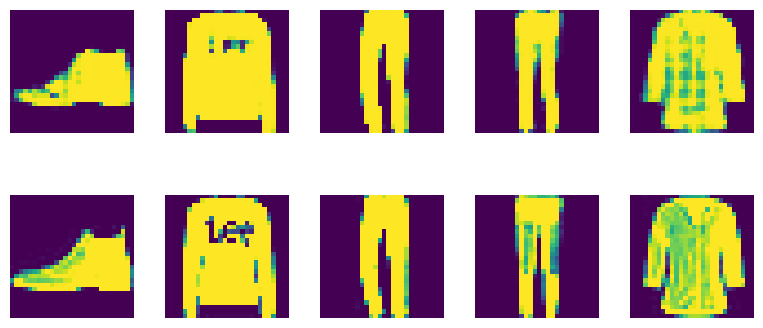

500/500 [==============================] - 27s 54ms/step - mse: 0.1221 - accuracy: 0.5439 - ssim: 0.9329 - gen_loss: 15.5517 - disc_loss: 15.4249 - val_mse: 0.1154 - val_accuracy: 0.5380 - val_ssim: 0.8421 - val_gen_loss: 15.5403 - val_disc_loss: 15.4249


In [18]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = f'logs/minst/minst_gan'
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = train_log_dir,
  write_graph=True,
  histogram_freq = 1,
  update_freq="batch"
  )

EPOCHS = 60
generator = AutoEncoder()
discriminator = Discriminator()
model = GAN(generator, discriminator)

class SkMetrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.validation_loss = []
        self.epoch_n = 0
        self.start = time.time()
        tf.summary.scalar("start_time", self.start )

    def on_train_end(self, logs={}):
        self.end = time.time()
        tf.summary.scalar("end_time", self.end )
        tf.summary.scalar("training_time", self.end-self.start)

    def on_epoch_begin(self, epoch, logs):
        self.epoch_start = time.time()
        tf.summary.scalar("epoch_start_time", self.epoch_start, step=epoch)

    def on_epoch_end(self, epoch, logs):
        self.epoch_n = epoch
        self.epoch_end = time.time()
        tf.summary.scalar("epoch_end_time", self.epoch_end, step=epoch)
        tf.summary.scalar("epoch_total_time", self.epoch_end-self.epoch_start, step=epoch)

    def on_batch_end(self, batch, logs={}):
        def expand_and_predict(x):
            gen = model.generator(x, training=False)
            t = discriminator(x)
            f = discriminator(gen)
            print(f"t={t}")
            print(f"f={f}")
            
            return gen
        if batch % 499 == 0 and batch > 0:
            display.clear_output()
            dm.print_validation(expand_and_predict)
        
class GeneratorLoss(keras.losses.Loss):
    def __init__(self, name="GeneratorLoss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        print("genloss")
        return generator_loss(y_true, y_pred)
    
class DiscriminatorLoss(keras.losses.Loss):
    def __init__(self, name="DiscriminatorLoss"):
        print("discloss")
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        return discriminator_loss(y_true, y_pred)


boundaries = [steps_per_epoch*10, steps_per_epoch*25, steps_per_epoch*60, steps_per_epoch*90, steps_per_epoch*95]
values = [0.001, 0.00075, 0.0005, 0.0001, 0.00005, 0.00001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

cross_entropy = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# model.compile(run_eagerly=True)
#
generator.compile(loss="mse", optimizer=opt, metrics=["mse", "accuracy", SSIM()])
generator.fit(dm.get_training_data(BATCH_SIZE).repeat(), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=dm.get_test_data(BATCH_SIZE), callbacks=[SkMetrics(), tboard_callback])
generator.encoder.trainable = False


t=[[-4.396401 ]
 [-5.3071184]
 [-4.182852 ]
 [-3.7709558]
 [-4.5003576]]
f=[[-3.2515943]
 [-4.1831484]
 [-2.782238 ]
 [-2.6682422]
 [-3.8942657]]


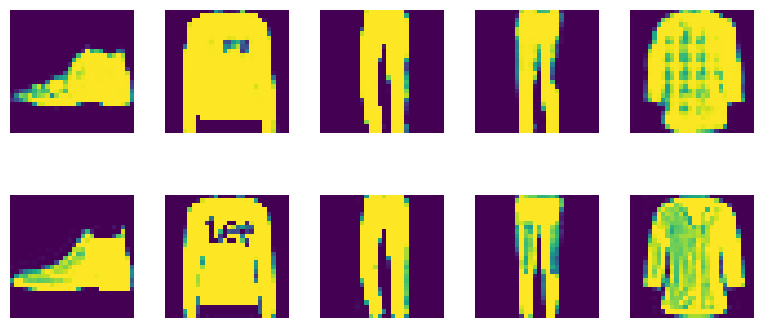

500/500 [==============================] - 28s 55ms/step - mse: 0.1226 - accuracy: 0.5439 - ssim: 0.9303 - gen_loss: 15.5527 - disc_loss: 15.4249 - val_mse: 0.1160 - val_accuracy: 0.5357 - val_ssim: 0.8326 - val_gen_loss: 15.5409 - val_disc_loss: 15.4249
Epoch 60/100
227/500 [============>.................] - ETA: 13s - mse: 0.1226 - accuracy: 0.5439 - ssim: 0.9279 - gen_loss: 15.5527 - disc_loss: 15.4250

KeyboardInterrupt: 

In [20]:
model = GAN(generator, discriminator)
model.compile(metrics=["mse", "accuracy", SSIM()])
history = model.fit(dm.get_training_data(BATCH_SIZE).repeat(), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=dm.get_test_data(BATCH_SIZE), callbacks=[SkMetrics(), tboard_callback])


In [ ]:
n = next(iter(dm.get_test_data(BATCH_SIZE)))
resized, images =n
p = model(n)
p1, p2 = p


plt.figure()
plt.imshow(resized[1])

plt.figure()
plt.imshow(p1[1])

plt.figure()
plt.imshow(p2[1])